In [3]:
!pip3 install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 584.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.0 MB/s eta 0:00:00a 0:00:01


In [4]:
import os
import tempfile
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import sys
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

import cv2
import glob
from torch.utils.data import Dataset, DataLoader

from generative.inferers import DiffusionInferer
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet
from generative.networks.schedulers.ddim import DDIMScheduler

torch.multiprocessing.set_sharing_strategy("file_system")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print_config()

MONAI version: 1.2.0
Numpy version: 1.26.0
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/default/miniconda3/envs/monai_generative_ai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN V

In [5]:
from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscreted,
    Compose,
    LoadImaged,
    Orientationd,
    Randomizable,
    Resized,
    ScaleIntensityd,
    Spacingd,
    EnsureTyped,
)

from monai.data import CacheDataset

In [6]:
import matplotlib.pyplot as plt

In [7]:
set_determinism(42)

In [12]:
train_files = glob.glob('osteoarthitis/train/train/*',recursive = True)
val_files = glob.glob('osteoarthitis/Valid/Valid/*',recursive = True)

In [13]:
print(train_files)
print(val_files)

['osteoarthitis/train/train/Normal', 'osteoarthitis/train/train/Osteoarthritis']
['osteoarthitis/Valid/Valid/Normal', 'osteoarthitis/Valid/Valid/Osteoarthritis']


In [80]:
class CustomDataset(Dataset):
  def __init__(self,path):
    self.imgs_path = path
    file_list = glob.glob(self.imgs_path+ "*")

    self.data=[]
    for class_path in file_list:
      class_name = class_path.split("/")[-1]
      for img_path in glob.glob(class_path+"/*"):
        self.data.append([img_path,1 if class_name=="Normal" else 2])

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    img_path,class_id = self.data[idx]
    img = cv2.imread(img_path)
    img = cv2.resize(img,(64,64)) # resizing here
    gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray_image.resize(64,64,1)
    img_tensor = torch.from_numpy(gray_image*0.3)
    img_tensor = img_tensor.permute(2,0,1)
    class_id = torch.tensor([class_id])
    img_tensor /= 255.
    return img_tensor , class_id

In [81]:
## Define the custom dataset
training_dataset = CustomDataset('osteoarthitis/train/train/')
validation_dataset = CustomDataset('osteoarthitis/Valid/Valid/')

In [82]:
len(training_dataset)

2350

In [83]:
len(validation_dataset)

641

In [84]:
data_loader = DataLoader(training_dataset,batch_size=4,shuffle=True)
for i,batch in enumerate(data_loader):
  break

In [89]:
X, y = batch

In [91]:
X[0, 0].max()

tensor(0.2718, dtype=torch.float64)

tensor([1])


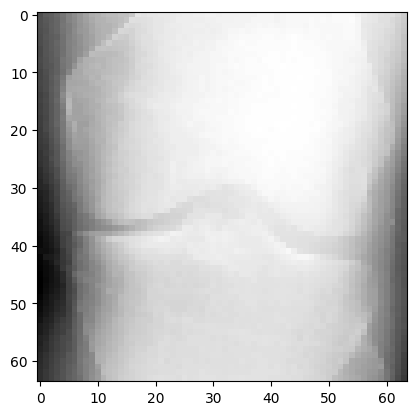

In [94]:
data_loader = DataLoader(training_dataset,batch_size=4,shuffle=True)
for img,label in data_loader:
  break
image =img[0]
print(label[0])
plt.imshow(image.permute(1,2,0),cmap="gray")
plt.show()

In [105]:
## Design the diffusion architechture

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
embedding_dimension = 64
model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=16,
    with_conditioning=True,
    cross_attention_dim=embedding_dimension,
).to(device)
embed = torch.nn.Embedding(num_embeddings=3, embedding_dim=embedding_dimension, padding_idx=0).to(device)

scheduler = DDIMScheduler(num_train_timesteps=3000)
optimizer = torch.optim.Adam(params=list(model.parameters()) + list(embed.parameters()), lr=1e-5)

inferer = DiffusionInferer(scheduler)

In [106]:
condition_dropout = 0.15
n_iterations = 2e4
batch_size = 64
val_interval = 100
iter_loss_list = []
val_iter_loss_list = []
iterations = []
iteration = 0
iter_loss = 0
# train_loader = DataLoader(training_dataset,batch_size=64,num_workers=4,shuffle=True)
train_loader = DataLoader(
    training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)
val_loader = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True
)
scaler = GradScaler()
total_start = time.time()

save_model_interval = 500
save_counter = 0

while iteration < n_iterations:
    for images,labels in train_loader:

        if save_counter == save_model_interval:
            #save the model
            print("saving model")
            torch.save({
                'epoch': iteration,
                'model_state_dict': model.state_dict(),
                'embed_state_dict':embed.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, f"checkpoints/{iteration}.tar")

            save_counter = 0
        save_counter+=1
        iteration+=1
        model.train()
        images = images.float()
        images,classes = images.to(device),labels.to(device)
        classes = classes.squeeze()
        classes = classes * (torch.rand_like(classes.float())>condition_dropout)
        class_embedding = embed(classes.long().to(device)).unsqueeze(1)
        optimizer.zero_grad(set_to_none=True)
        timesteps = torch.randint(0,1000,(len(images),)).to(device)
        with autocast(enabled=True):
            noise = torch.randn_like(images).to(device)
            noise_pred = inferer(inputs=images,diffusion_model=model,noise=noise,
                  timesteps=timesteps,condition=class_embedding              )
            loss = F.mse_loss(noise_pred.float(),noise.float())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            iter_loss+=loss.item()
            sys.stdout.write(f"Iteration {iteration}/{n_iterations} - train Loss {loss.item():.4f}" + "\r")
            sys.stdout.flush()
            if (iteration) % val_interval == 0:
                model.eval()
                val_iter_loss = 0
                for val_step, val_batch in enumerate(val_loader):
                    images, classes = val_batch[0].to(device), val_batch[1].to(device)
                    images = images.float()
                    classes = classes.squeeze()
                    class_embedding = embed(classes.long().to(device)).unsqueeze(1)
                    timesteps = torch.randint(0, 1000, (len(images),)).to(device)
                    with torch.no_grad():
                        with autocast(enabled=True):
                            noise = torch.randn_like(images).to(device)
                            noise_pred = inferer(
                                    inputs=images,
                                    diffusion_model=model,
                                    noise=noise,
                                    timesteps=timesteps,
                                    condition=class_embedding,
                                )
                            val_loss = F.mse_loss(noise_pred.float(), noise.float())
                    val_iter_loss += val_loss.item()
                iter_loss_list.append(iter_loss / val_interval)
                val_iter_loss_list.append(val_iter_loss / (val_step + 1))
                iterations.append(iteration)
                iter_loss = 0
                print(
                    f"Train Loss {loss.item():.4f}, Interval Loss {iter_loss_list[-1]:.4f}, Interval Loss Val {val_iter_loss_list[-1]:.4f}"
                )


total_time = time.time() - total_start
print(f"train diffusion completed, total time: {total_time}.")




Train Loss 0.8090, Interval Loss 0.9119, Interval Loss Val 0.8091
Train Loss 0.6081, Interval Loss 0.7045, Interval Loss Val 0.6091
Train Loss 0.4470, Interval Loss 0.5232, Interval Loss Val 0.4446
Train Loss 0.3207, Interval Loss 0.3783, Interval Loss Val 0.3196
Train Loss 0.2304, Interval Loss 0.2697, Interval Loss Val 0.2272
saving model
Train Loss 0.1559, Interval Loss 0.1905, Interval Loss Val 0.1599
Train Loss 0.1104, Interval Loss 0.1331, Interval Loss Val 0.1108
Train Loss 0.0765, Interval Loss 0.0913, Interval Loss Val 0.0754
Train Loss 0.0507, Interval Loss 0.0619, Interval Loss Val 0.0526
Train Loss 0.0323, Interval Loss 0.0410, Interval Loss Val 0.0348
saving model
Train Loss 0.0225, Interval Loss 0.0275, Interval Loss Val 0.0227
Train Loss 0.0195, Interval Loss 0.0186, Interval Loss Val 0.0153
Train Loss 0.0104, Interval Loss 0.0127, Interval Loss Val 0.0111
Train Loss 0.0061, Interval Loss 0.0092, Interval Loss Val 0.0075
Train Loss 0.0065, Interval Loss 0.0070, Interval 

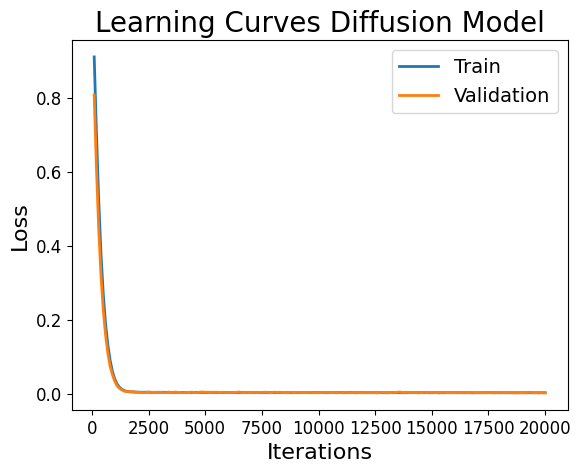

In [107]:
# plt.style.use("seaborn-bright")
plt.title("Learning Curves Diffusion Model", fontsize=20)
plt.plot(iterations, iter_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
        iterations, val_iter_loss_list, color="C1", linewidth=2.0, label="Validation"
    )  # np.linspace(1, n_iterations, len(val_iter_loss_list))
plt.yticks(fontsize=12), plt.xticks(fontsize=12)
plt.xlabel("Iterations", fontsize=16), plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()


In [40]:
# torch.save({
#                 'epoch': iteration,
#                 'model_state_dict': model.state_dict(),
#                 'embed_state_dict':embed.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': loss,
#                 }, "test.tar")

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:48<00:00, 61.90it/s]


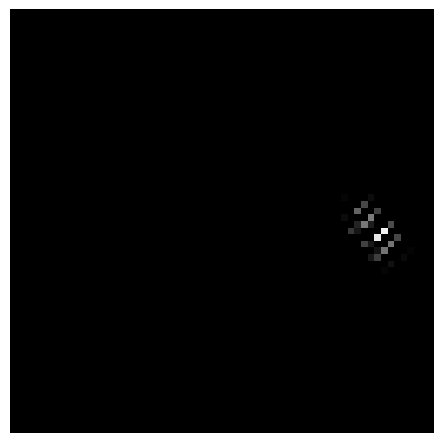

In [109]:
#Model evaluation

model.eval()
scheduler.clip_sample = True
guidance_scale = 3
conditioning = torch.cat([torch.zeros(1).long(), 2 * torch.ones(1).long()], dim=0).to(
    device
)  # 2*torch.ones(1).long() is the class label for the UNHEALTHY (tumor) class
class_embedding = embed(conditioning).unsqueeze(
    1
)  # cross attention expects shape [batch size, sequence length, channels]
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=3000)
progress_bar = tqdm(scheduler.timesteps)
for t in progress_bar:
    with autocast(enabled=True):
        with torch.no_grad():
            noise_input = torch.cat([noise] * 2)
            model_output = model(noise_input, timesteps=torch.Tensor((t,)).to(noise.device), context=class_embedding)
            noise_pred_uncond, noise_pred_text = model_output.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    noise, _ = scheduler.step(noise_pred, t, noise)

plt.style.use("default")
plt.imshow(noise[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [112]:
noise.shape

torch.Size([1, 1, 64, 64])

In [130]:
import random

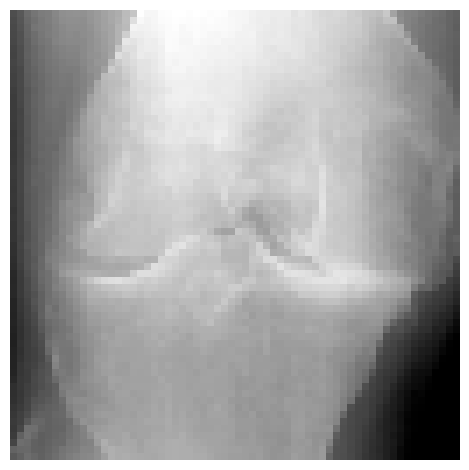

input label:  tensor([2])


In [148]:
train_loader_ = DataLoader(
    training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)
for train_batch in train_loader_:
    break

idx_unhealthy = np.argwhere(train_batch[1].numpy() == 2).squeeze()

idx = idx_unhealthy[random.randint(0, 64)]  # Pick a random slice of the validation set to be transformed
inputting = val_batch[0][idx[0]]  # Pick an input slice of the validation set to be transformed
inputlabel = val_batch[1][idx[0]]  # Check whether it is healthy or diseased

plt.figure("input" + str(inputlabel))
plt.imshow(inputting[0], cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

model.eval()
print("input label: ", inputlabel)

In [149]:
model.eval()

guidance_scale = 3.0
total_timesteps = 1500
latent_space_depth = int(total_timesteps * 0.25)

current_img = inputting[None, ...].to(device)
current_img = current_img.float()
scheduler.set_timesteps(num_inference_steps=total_timesteps)

## Encoding

scheduler.clip_sample = False
class_embedding = embed(torch.zeros(1).long().to(device)).unsqueeze(1)
progress_bar = tqdm(range(latent_space_depth))
for i in progress_bar:  # go through the noising process
    t = i
    with torch.no_grad():
        model_output = model(current_img, timesteps=torch.Tensor((t,)).to(current_img.device), context=class_embedding)
    current_img, _ = scheduler.reversed_step(model_output, t, current_img)
    progress_bar.set_postfix({"timestep input": t})

latent_img = current_img

## Decoding
conditioning = torch.cat([torch.zeros(1).long(), torch.ones(1).long()], dim=0).to(device)
class_embedding = embed(conditioning).unsqueeze(1)

progress_bar = tqdm(range(latent_space_depth))
for i in progress_bar:  # go through the denoising process
    t = latent_space_depth - i
    current_img_double = torch.cat([current_img] * 2)
    with torch.no_grad():
        model_output = model(
            current_img_double, timesteps=torch.Tensor([t, t]).to(current_img.device), context=class_embedding
        )
    noise_pred_uncond, noise_pred_text = model_output.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    current_img, _ = scheduler.step(noise_pred, t, current_img)
    progress_bar.set_postfix({"timestep input": t})
    torch.cuda.empty_cache()

100%|██████████████████████████████████████████████████████████████████████████████| 375/375 [00:04<00:00, 81.96it/s, timestep input=1]


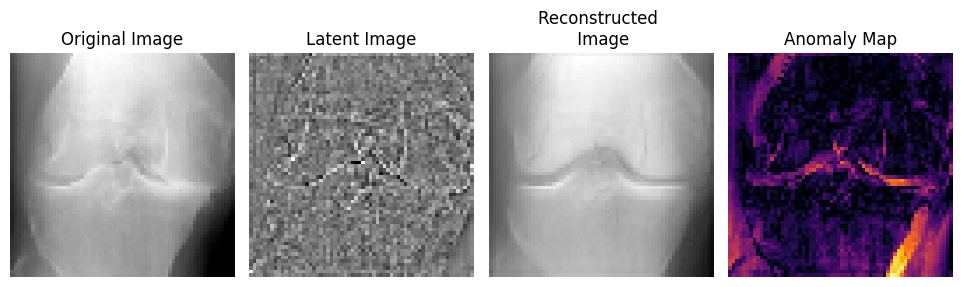

In [151]:
def visualize(img):
    _min = img.min()
    _max = img.max()
    normalized_img = (img - _min) / (_max - _min)
    return normalized_img


diff = abs(inputting.cpu() - current_img[0].cpu()).detach().numpy()
row = 4
plt.style.use("default")

fig = plt.figure(figsize=(10, 30))

ax = plt.subplot(1, row, 2)
# ax.imshow(latent_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
ax.imshow(latent_img[0, 0].cpu().detach().numpy(), cmap="gray")
ax.set_title("Latent Image"), plt.tight_layout(), plt.axis("off")

ax = plt.subplot(1, row, 3)
# ax.imshow(current_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
ax.imshow(current_img[0, 0].cpu().detach().numpy(), cmap="gray")
ax.set_title("Reconstructed \n Image"), plt.tight_layout(), plt.axis("off")


ax = plt.subplot(1, row, 4)
ax.imshow(diff[0], cmap="inferno")
ax.set_title("Anomaly Map"), plt.tight_layout(), plt.axis("off")

ax = plt.subplot(1, row, 1)
# ax.imshow(inputting[0], vmin=0, vmax=1, cmap="gray")
ax.imshow(inputting[0], cmap="gray")
ax.set_title("Original Image"), plt.tight_layout(), plt.axis("off")
plt.show()

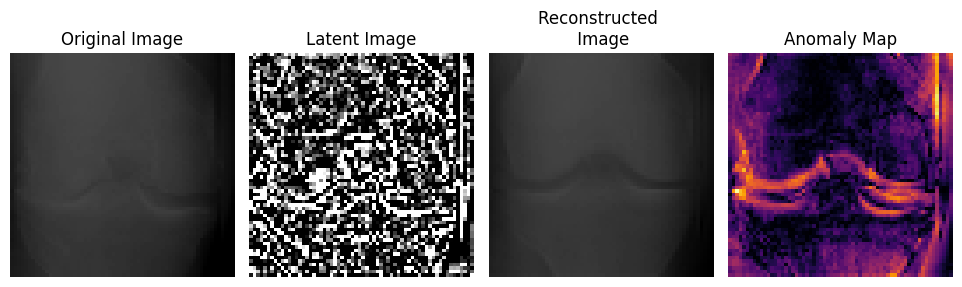

In [144]:
def visualize(img):
    _min = img.min()
    _max = img.max()
    normalized_img = (img - _min) / (_max - _min)
    return normalized_img


diff = abs(inputting.cpu() - current_img[0].cpu()).detach().numpy()
row = 4
plt.style.use("default")

fig = plt.figure(figsize=(10, 30))

ax = plt.subplot(1, row, 2)
ax.imshow(latent_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
ax.set_title("Latent Image"), plt.tight_layout(), plt.axis("off")

ax = plt.subplot(1, row, 3)
ax.imshow(current_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
ax.set_title("Reconstructed \n Image"), plt.tight_layout(), plt.axis("off")


ax = plt.subplot(1, row, 4)
ax.imshow(diff[0], cmap="inferno")
ax.set_title("Anomaly Map"), plt.tight_layout(), plt.axis("off")

ax = plt.subplot(1, row, 1)
ax.imshow(inputting[0], vmin=0, vmax=1, cmap="gray")
ax.set_title("Original Image"), plt.tight_layout(), plt.axis("off")
plt.show()